In [74]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spacy
import textacy
from glob import glob
import ete3
from ete3 import Tree, TreeStyle, TextFace, add_face_to_node
from sklearn.decomposition import PCA
%matplotlib inline
plt.rcParams['figure.figsize'] = (24,12)
plt.style.use('ggplot')

In [2]:
james = textacy.Corpus.load('.', 'james', compression='gzip')

In [197]:
class SentenceTree(): 
    def __init__(self, sent): 
        """ Takes a SpaCy sentence as input. """ 
        self.sent = sent
        self.root = sent.root
#         print(self.sent)
        self.sentDict = self.sentToDict(self.root)
        self.newick = self.newickify(self.sentDict) + ';'
        self.tree = Tree(self.newick, format=1)
        self.vector = self.countLevels(self.sent)
        self.max = max(self.vector)
        # The total depth
        self.maxDist = self.tree.get_farthest_leaf()[1]
        # The number of total descendants at each branch. 
        self.branchDepth = [len(branch.get_descendants()) for branch in self.tree.children]
        self.branchDepthSTD = pd.Series(self.branchDepth).std()
        
    def countLevels(self, sent):
        """ Create a numeric representation vector of a syntactic tree by counting the numbers
        of child nodes at each level of the tree. """
#         print('Counting levels for sentence: ', sent)
        sentRoot = sent.root
        counts = [1, len(list(sentRoot.children))]
        branches = list(sentRoot.children)
        children = []
        while branches != []: 
    #         print('---Branches: ', branches)
            for branch in branches: 
    #             print('Branch: ', branch)
    #             print('Children: ', list(branch.children))
                for child in list(branch.children): 
                    children.append(child)
    #             print('Children list: ', children)
            counts.append(len(children))
            branches = children.copy()
            children = []
        return counts
    
    def isPunct(self, thing): 
        if type(thing) == str: 
            if thing.strip() in "!@#$%^&*()_+-=,./<>?;'\":[]\{}|`~": 
                return True
        return False

    def sentToDict(self, node): 
        children = [child for child in node.children 
                   if self.isPunct(child.string.strip()) == False # ignore punctuation
                   and child.tag_ != 'SP'] #ignore spaces and newlines
        root = node.string.strip()
        if len(children) == 0: 
            return node.string.strip()
        return {node.string.strip(): [self.sentToDict(child) 
                                      for child in children]}

    def newickify(self, node): 
        if type(node) == str:
            return node.strip()
        root = list(node)[0]
        return '(' + ','.join([self.newickify(child) 
            for child in node[root] ]) + ')' + root
    
    def render(self, textMode=False, radial=True): 
        """ 
        textMode=False will show a graphical tree. 
        textmode=True will show an ASCII tree. 
        """
        t = self.tree
        if textMode: 
            print(t.get_ascii(show_internal=True))
        else: 
            ts = TreeStyle()
            ts.show_leaf_name = False
            #TODO: make this not be a function
            def my_layout(node):
                F = TextFace(node.name, tight_text=False)
                add_face_to_node(F, node, column=0, position="branch-right")
            ts.layout_fn = my_layout
            if radial: 
                   ts.mode='c'
            return t.render('%%inline', tree_style=ts)

In [186]:
class SentenceStats(): 
    def __init__(self, doc): 
        """ Takes a SpaCy document as input. """
        self.doc = doc
        self.sents = list(doc.sents)
        self.sentObjs = [SentenceTree(sent) for sent in self.sents]
        self.vectors = [sent.vector for sent in self.sentObjs]
        self.maxes = [sent.max for sent in self.sentObjs]
        self.averageSent = self.averageVectors(self.vectors)

    def averageVectors(self, vectorList): 
        """ Does an element-wise average for all the vectors in a list. """
        lengths = [len(vector) for vector in vectorList]
        maxLength = max(lengths)
        for vector in vectorList: 
            while len(vector) < maxLength: 
                vector.append(0) # Zero-pad
        vectorList = np.array(vectorList)
        return vectorList.mean(axis=0) # average each column
    
    def plotAverageSent(self): 
        pd.Series(self.averageSent).plot(kind="bar")

In [175]:
longSents = []
for doc in james: 
    for sent in doc.sents: 
        if len(sent) > 200: 
            longSents.append((sent, doc.metadata['filename'], len(sent)))

In [119]:
len(longSents)

11

In [44]:
[sent[1] for sent in longSents]

['text/1897-what-maisie-knew.txt',
 'text/1886-bostonians.txt',
 'text/1880-portrait-of-a-lady.txt',
 'text/1902-wings-of-the-dove.txt',
 'text/1881-portrait-of-a-lady.txt',
 'text/1917-ivory-tower.txt',
 'text/1917-ivory-tower.txt',
 'text/1917-ivory-tower.txt',
 'text/1886-princess-casamassima.txt',
 'text/1886-princess-casamassima.txt',
 'text/1886-princess-casamassima.txt']

In [120]:
[sent[2] for sent in longSents]

[208, 217, 253, 206, 253, 253, 203, 236, 207, 226, 213]

In [187]:
t = SentenceTree(longSents[2][0])

In [199]:
for sent in longSents: 
    print(SentenceTree(sent[0]).branchDepthSTD)

30.0044639536
34.4501019419
32.4562892871
67.0944607748
32.4562892871
43.1369910865
41.3659625434
56.1456439391
54.5417271454
58.8359300655
47.1412770298


In [201]:
ls3 = SentenceTree(longSents[3][0])

In [205]:
ls3.branchDepthSTD

67.094460774840925

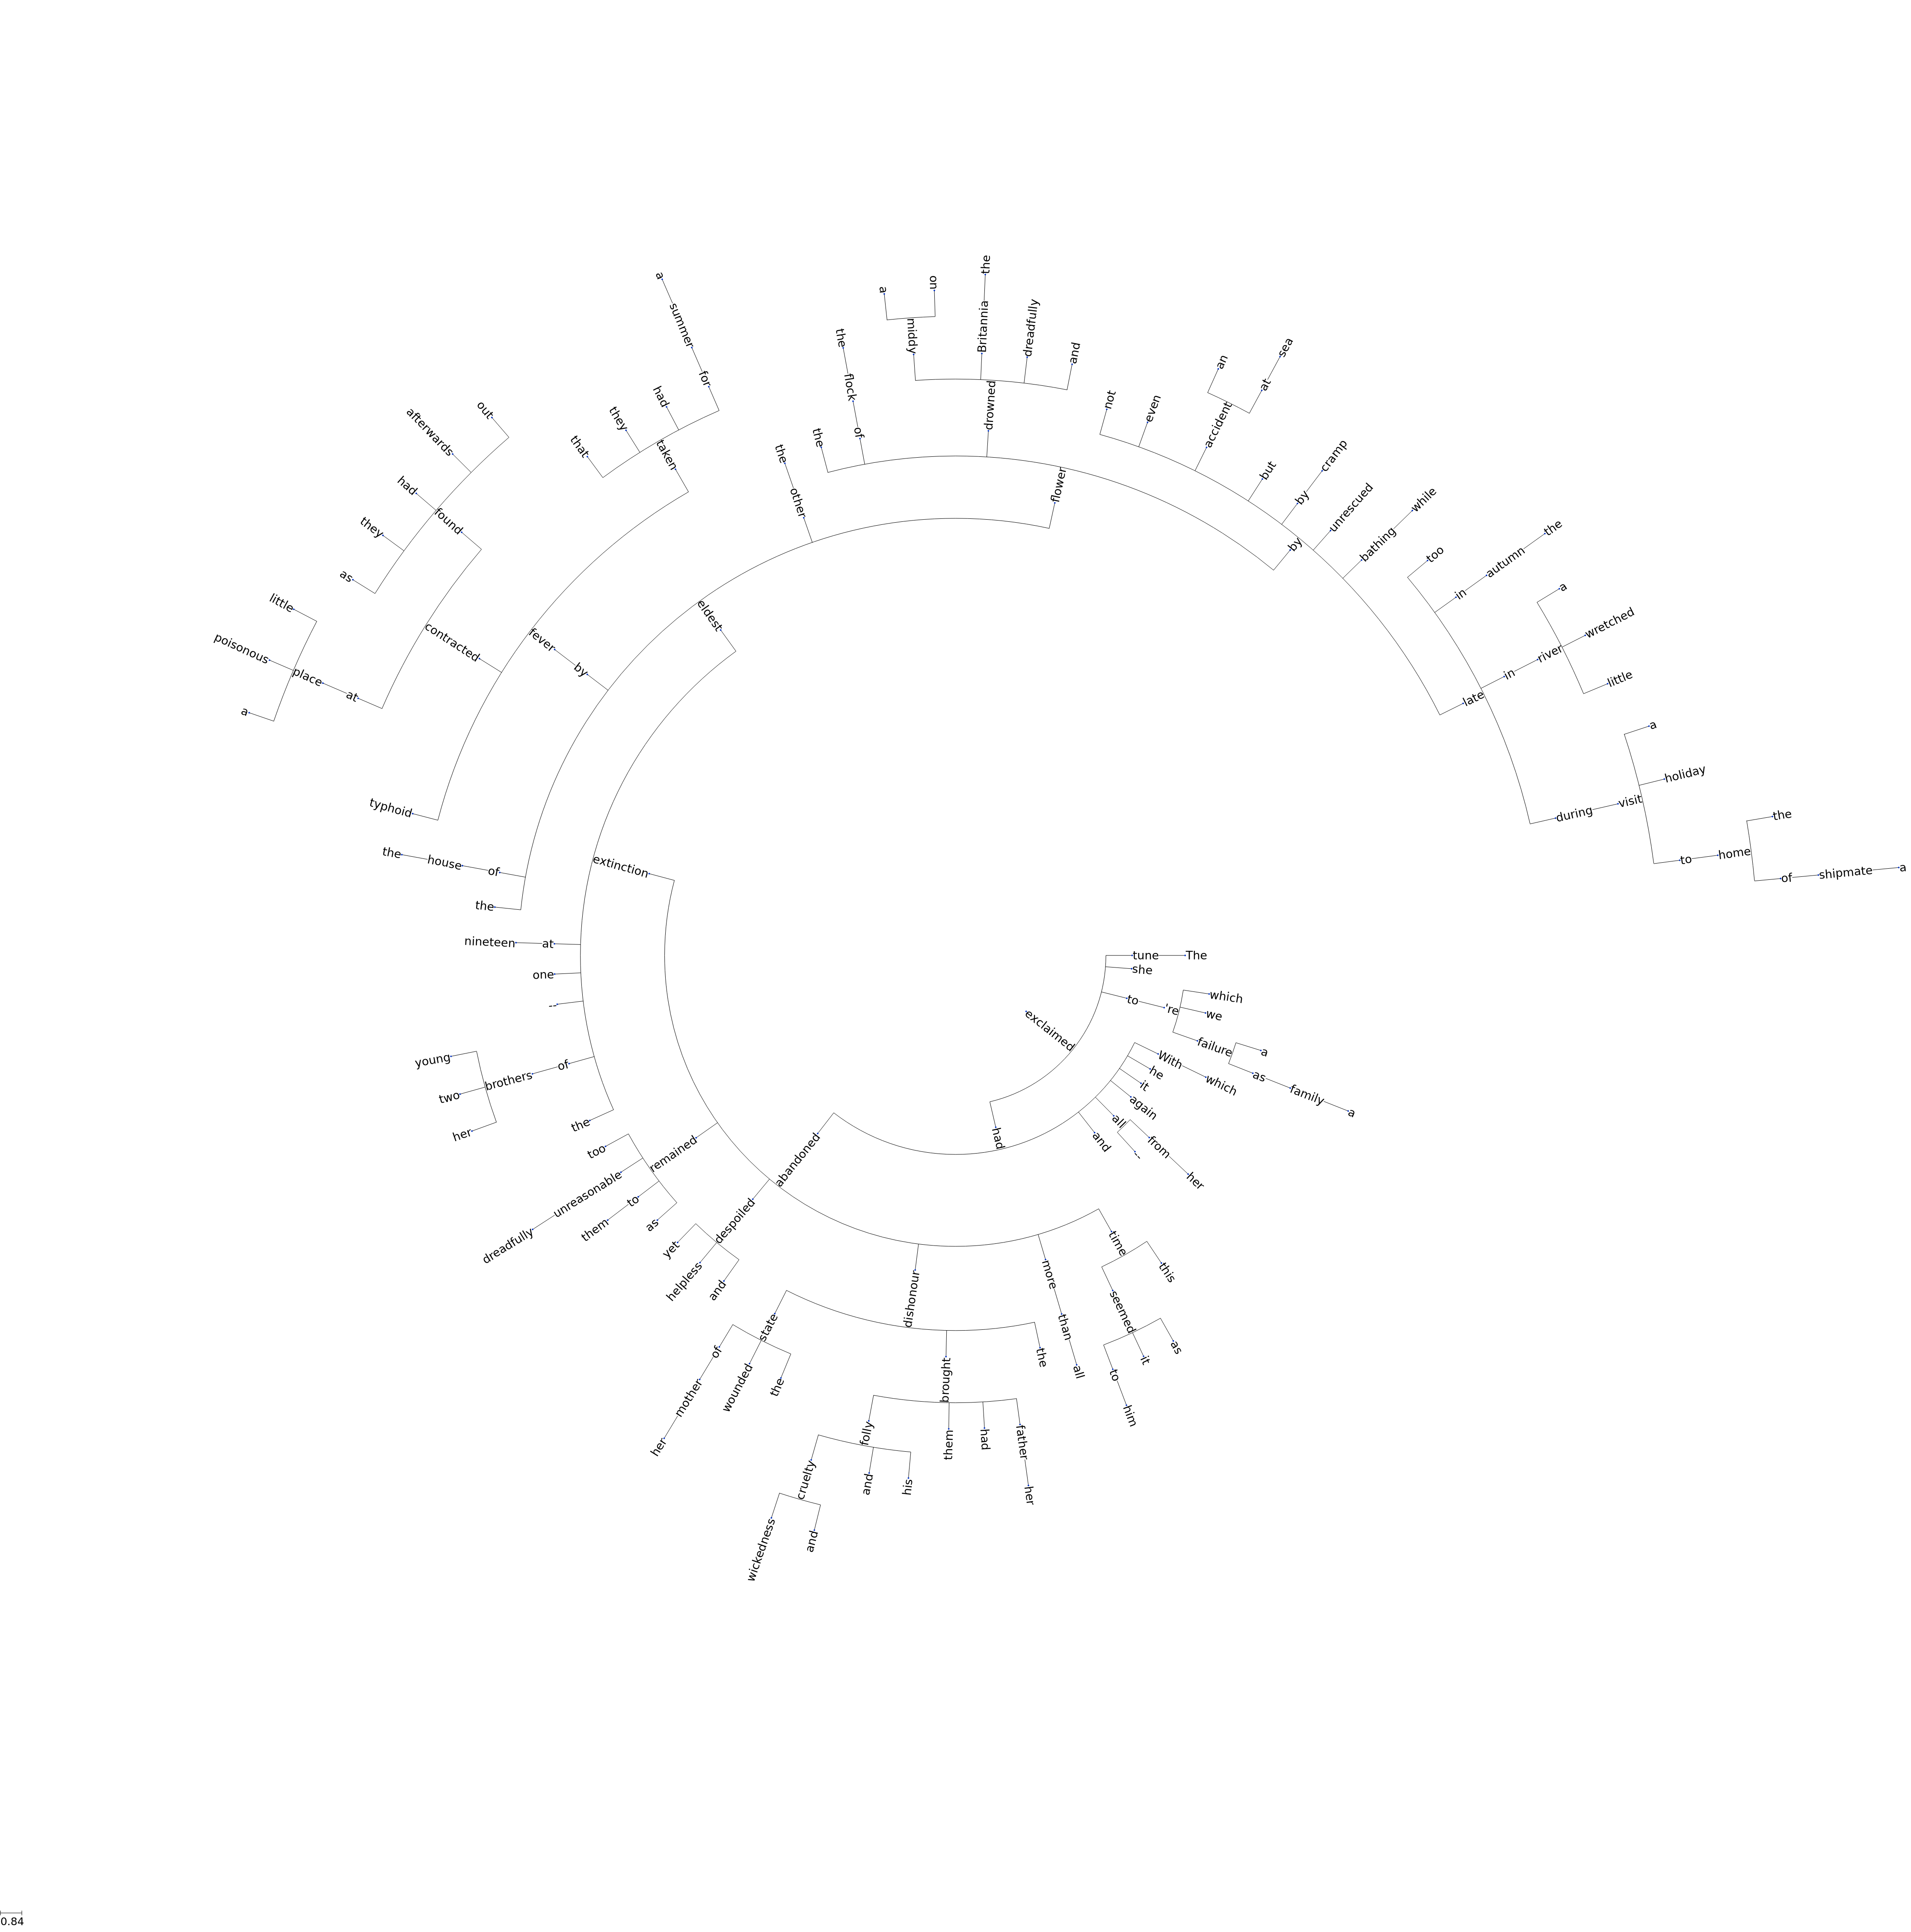

In [208]:
ls3.render()

The house had a name and a history; the old
gentleman taking his tea would have been delighted to tell you these
things: how it had been built under Edward the Sixth, had offered a
night’s hospitality to the great Elizabeth (whose august person had
extended itself upon a huge, magnificent and terribly angular bed which
still formed the principal honour of the sleeping apartments), had been
a good deal bruised and defaced in Cromwell’s wars, and then, under the
Restoration, repaired and much enlarged; and how, finally, after having
been remodelled and disfigured in the eighteenth century, it had passed
into the careful keeping of a shrewd American banker, who had bought it
originally because (owing to circumstances too complicated to set forth)
it was offered at a great bargain: bought it with much grumbling at its
ugliness, its antiquity, its incommodity, and who now, at the end of
twenty years, had become conscious of a real aesthetic passion for it,
so that he knew all its points and

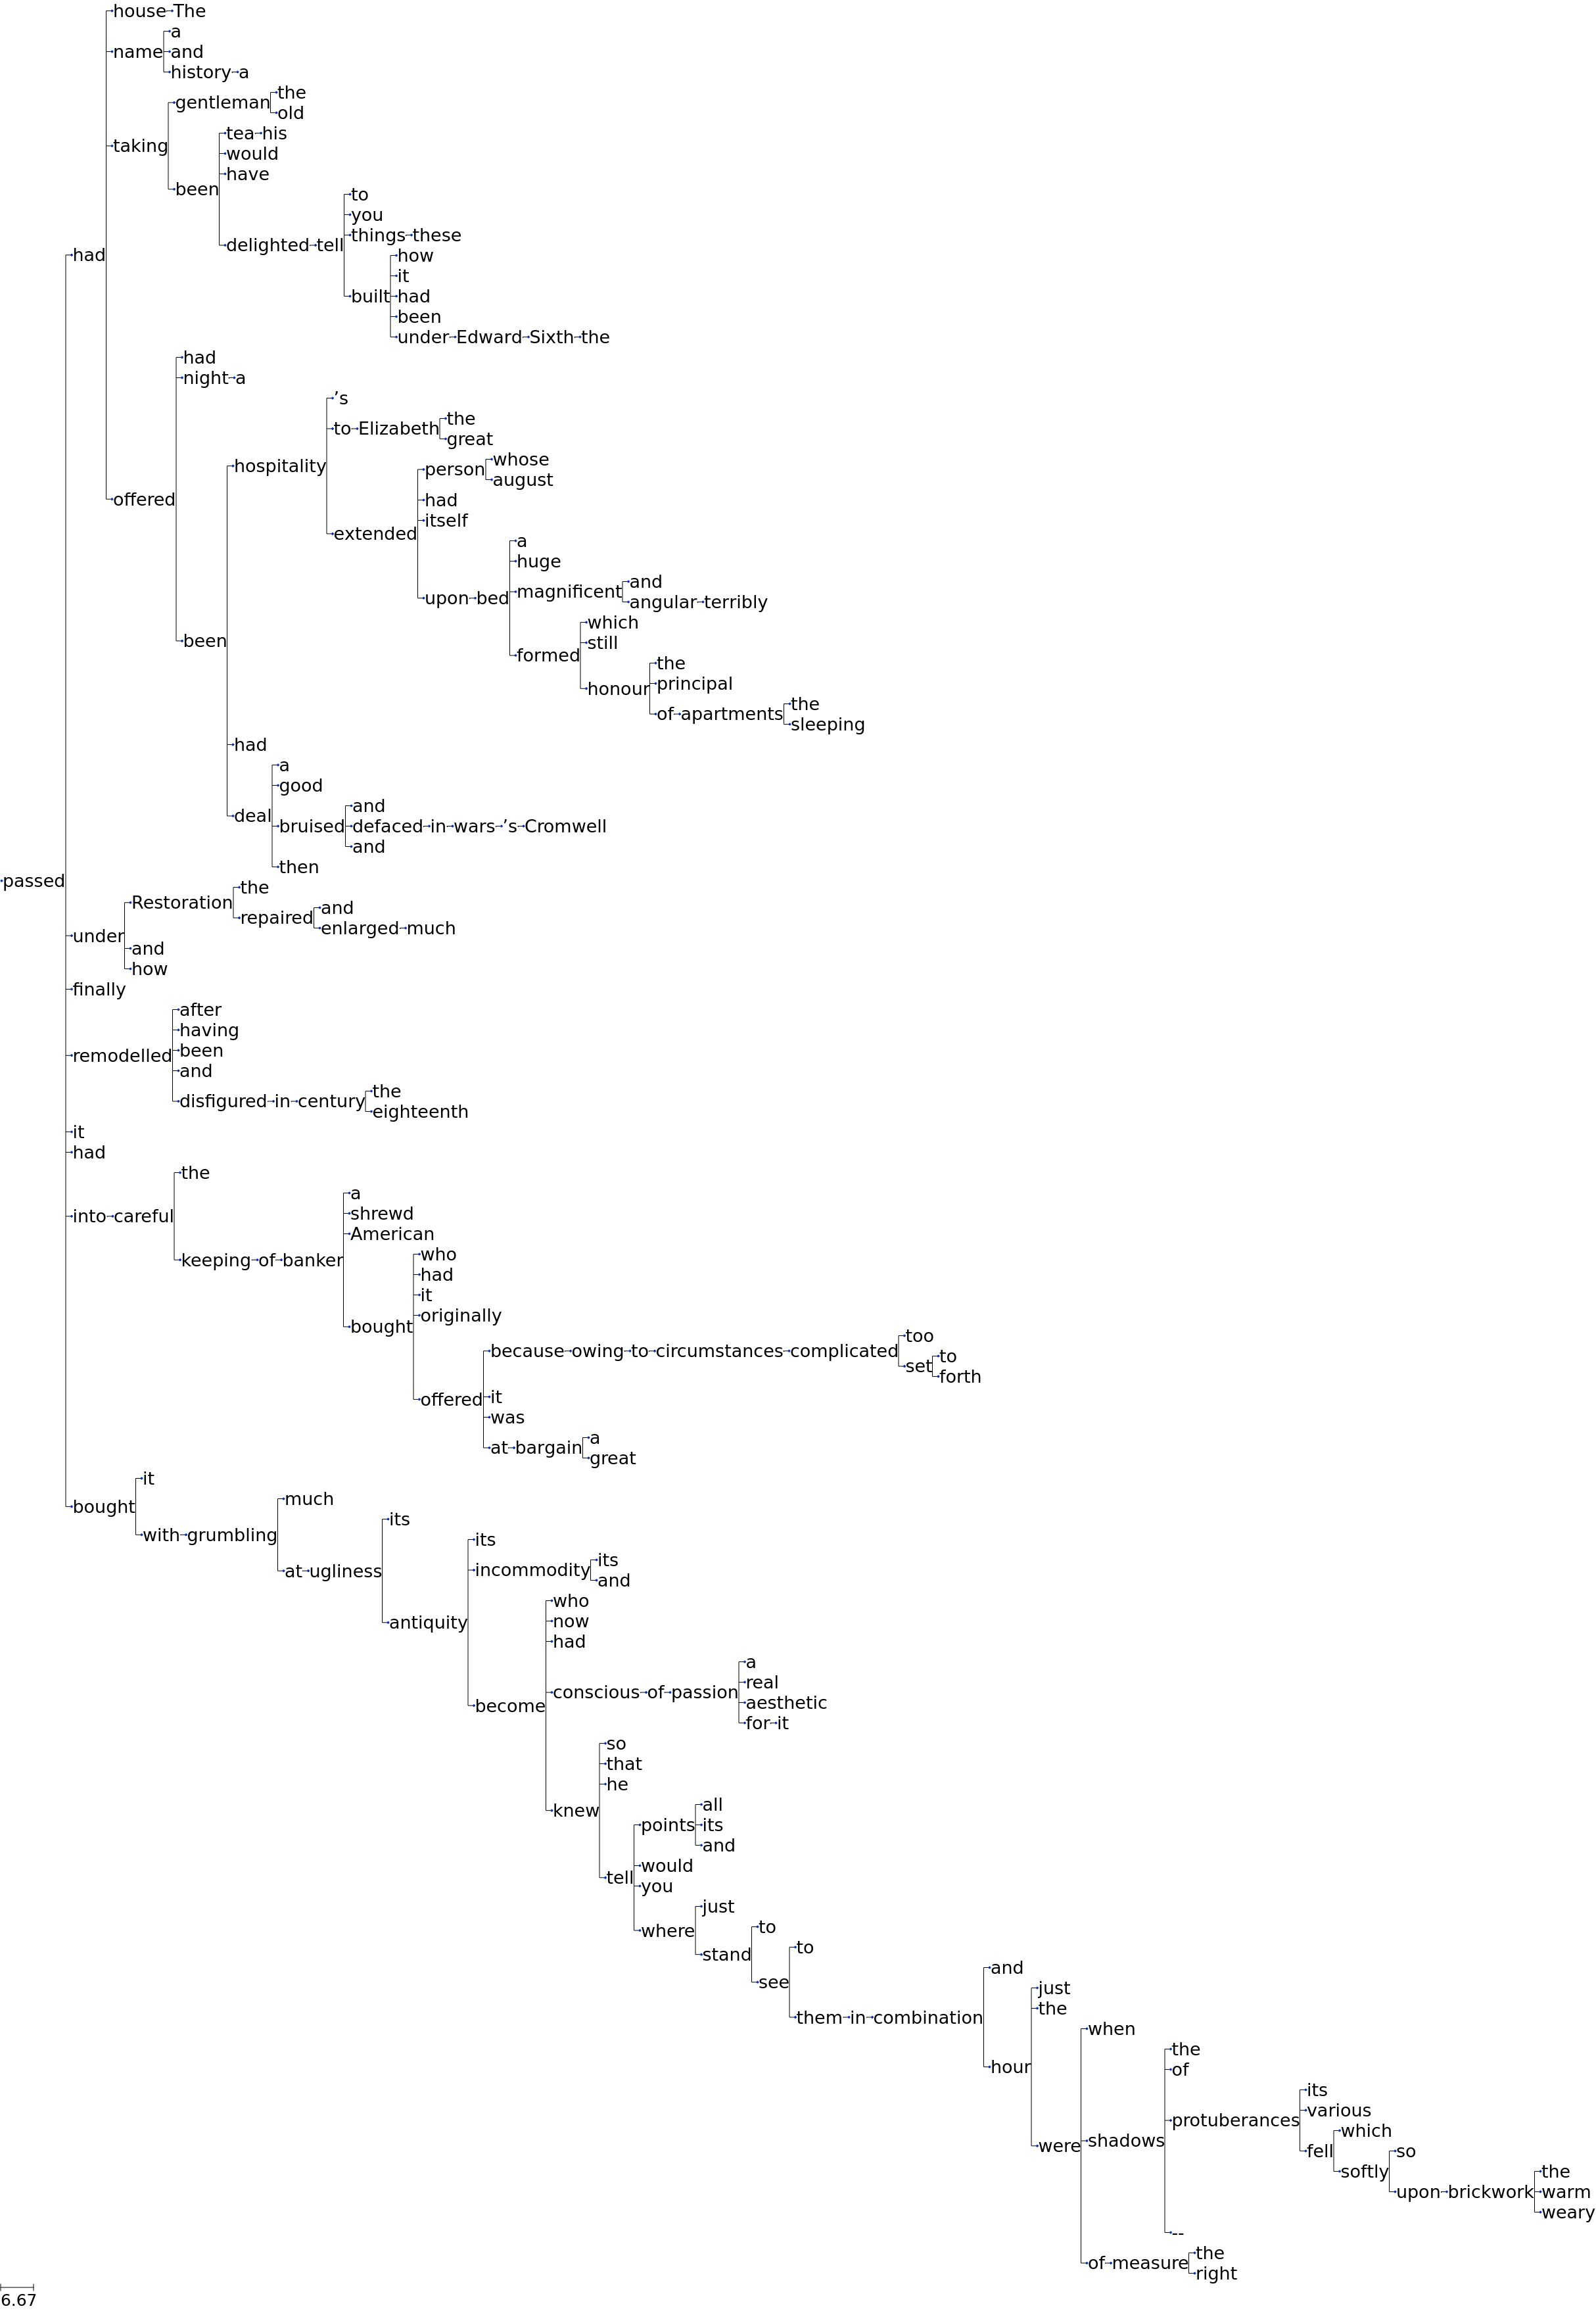

In [122]:
SentenceTree(longSents[2][0]).render(radial=False)

This edifice, a diminished
copy of the chapel of King's College, at the greater Cambridge, is a
rich and impressive institution; and as he stood there, in the bright,
heated stillness, which seemed suffused with the odour of old print and
old bindings, and looked up into the high, light vaults that hung over
quiet book-laden galleries, alcoves and tables, and glazed cases where
rarer treasures gleamed more vaguely, over busts of benefactors and
portraits of worthies, bowed heads of working students and the gentle
creak of passing messengers--as he took possession, in a comprehensive
glance, of the wealth and wisdom of the place, he felt more than ever
the soreness of an opportunity missed; but he abstained from expressing
it (it was too deep for that), and in a moment Verena had introduced him
to a young lady, a friend of hers, who, as she explained, was working on
the catalogue, and whom she had asked for on entering the library, at a
desk where another young lady was occupied.


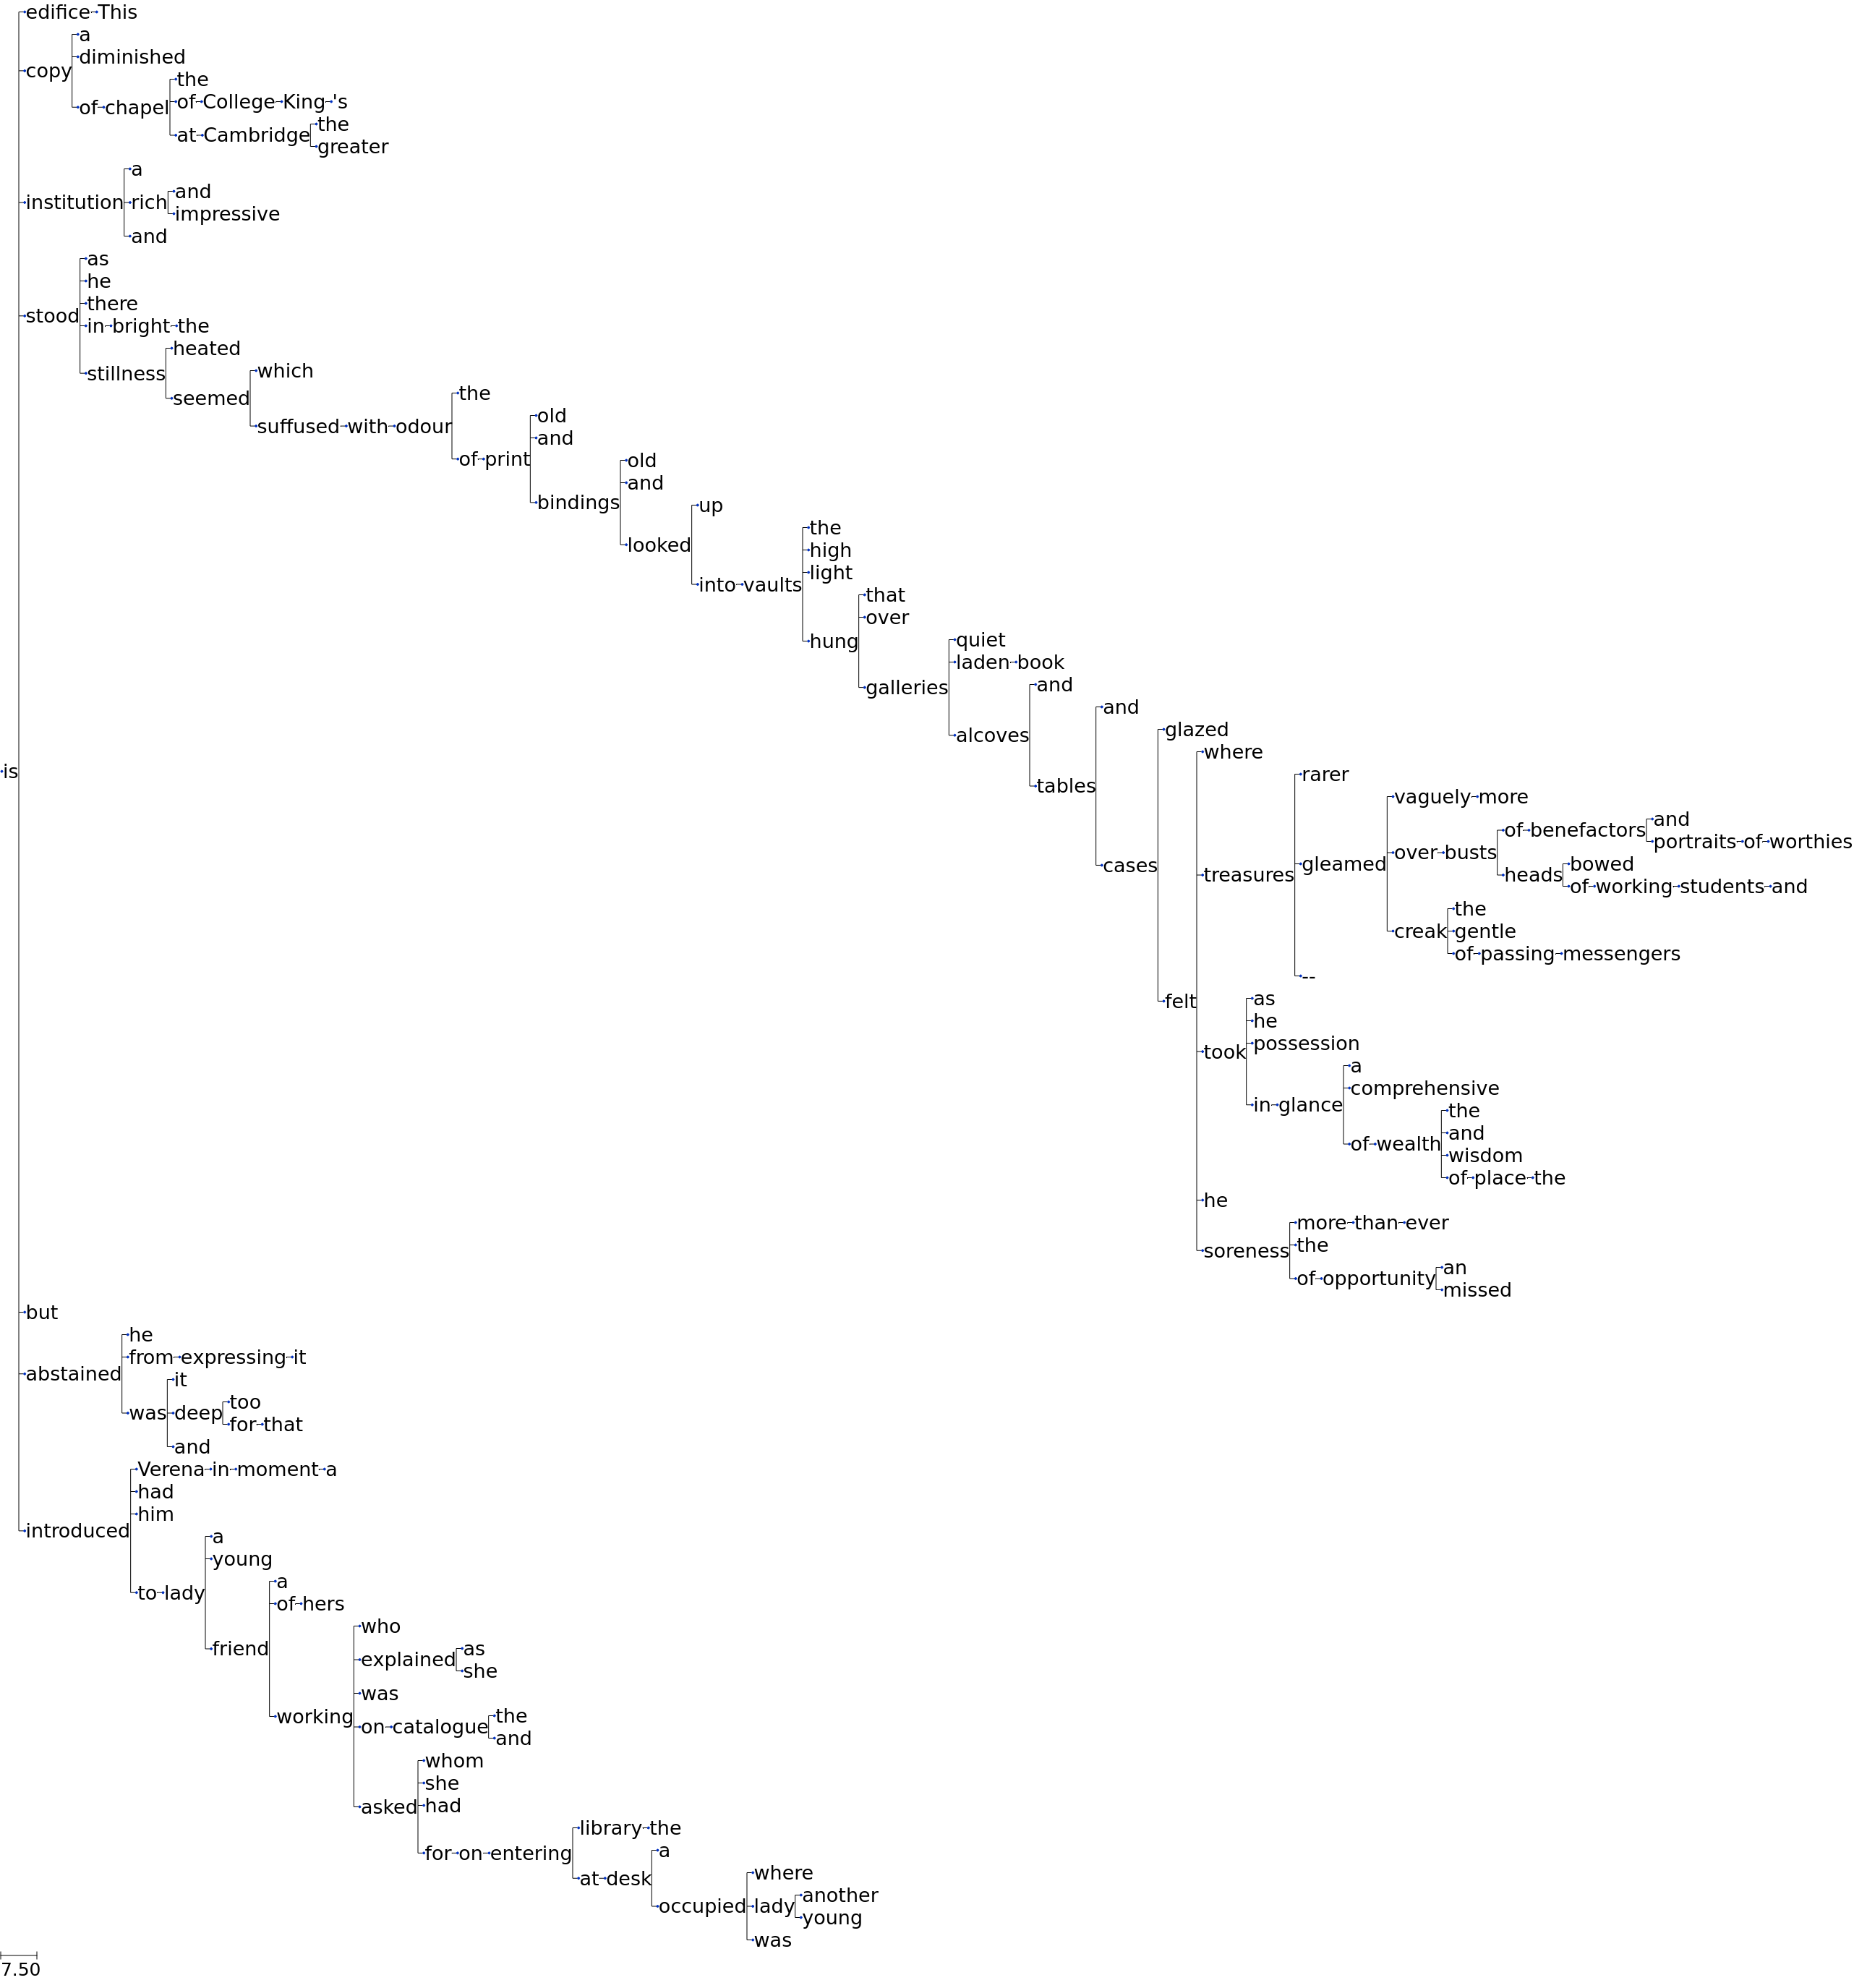

In [116]:
SentenceTree(longSents[1][0]).render(radial=False)

In [117]:
SentenceTree(longSents[1][0]).vector

This edifice, a diminished
copy of the chapel of King's College, at the greater Cambridge, is a
rich and impressive institution; and as he stood there, in the bright,
heated stillness, which seemed suffused with the odour of old print and
old bindings, and looked up into the high, light vaults that hung over
quiet book-laden galleries, alcoves and tables, and glazed cases where
rarer treasures gleamed more vaguely, over busts of benefactors and
portraits of worthies, bowed heads of working students and the gentle
creak of passing messengers--as he took possession, in a comprehensive
glance, of the wealth and wisdom of the place, he felt more than ever
the soreness of an opportunity missed; but he abstained from expressing
it (it was too deep for that), and in a moment Verena had introduced him
to a young lady, a friend of hers, who, as she explained, was working on
the catalogue, and whom she had asked for on entering the library, at a
desk where another young lady was occupied.


[1,
 8,
 23,
 20,
 16,
 9,
 13,
 12,
 5,
 4,
 8,
 4,
 3,
 9,
 5,
 5,
 4,
 3,
 2,
 6,
 11,
 7,
 13,
 7,
 8,
 4,
 4,
 2,
 1,
 0]

In [98]:
sentenceStats.countLevels(None, longSents[-2][0]

[1, 6, 19, 30, 24, 19, 32, 26, 18, 10, 6, 3, 7, 5, 4, 4, 1, 5, 5, 1, 0]

# Cluster by vectors

In [61]:
averages = [sentenceStats(doc).averageSent for doc in james]

In [63]:
labels = [doc.metadata['filename'] for doc in james]

In [65]:
df = pd.DataFrame(averages, index=labels)
df = df.fillna(0)

In [81]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(df)

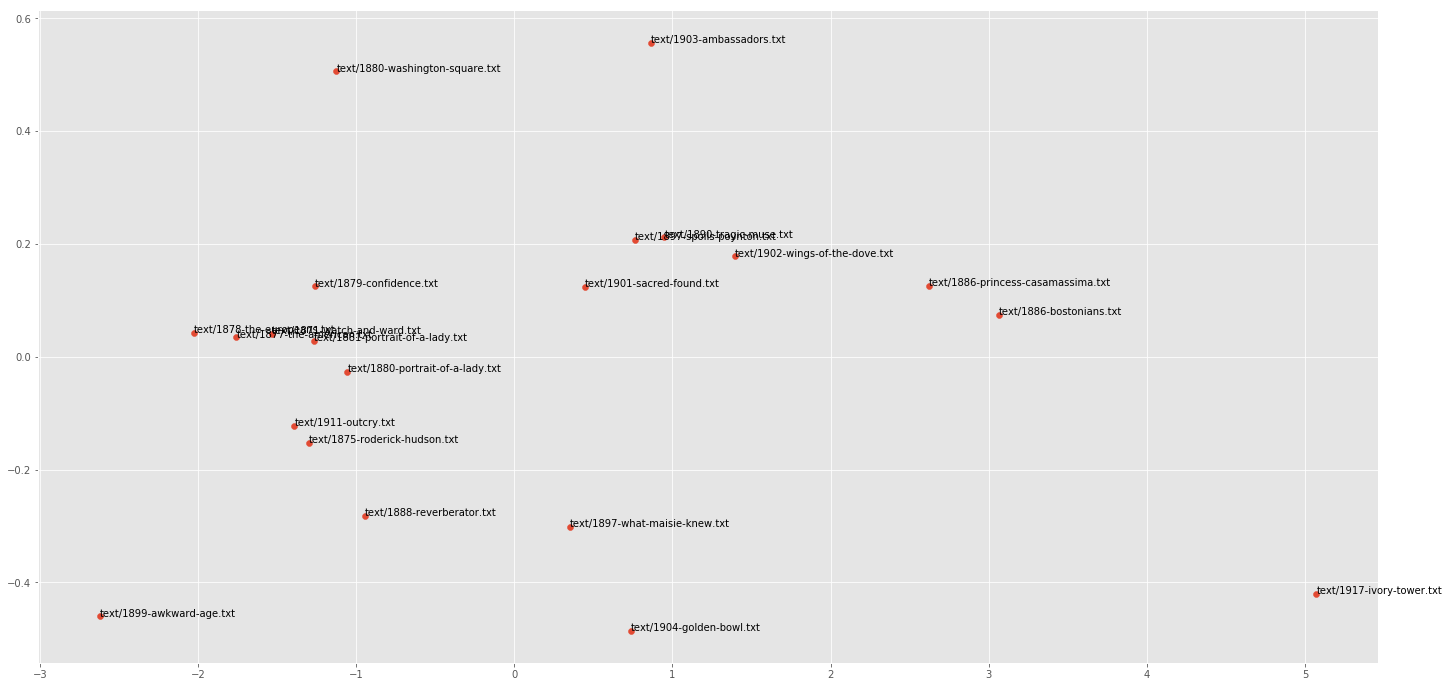

In [92]:
plt.scatter(reduced[:,0], reduced[:,1])
for line, label in zip(reduced, labels): 
    plt.annotate(label, line)

# Find the highest branch depth standard deviation ("digressiveness?")

In [210]:
branchSTDs = []
for doc in james: 
    for sent in doc.sents: 
        try: 
            st = SentenceTree(sent)
        except: 
            continue
        if st.branchDepthSTD > 50: 
            branchSTDs.append(st)

In [211]:
len(branchSTDs)

109

In [215]:
sortedBranchSTDs = sorted(branchSTDs, key=lambda x: x.branchDepthSTD)


In [216]:
sortedBranchSTDs[-1].branchDepthSTD

98.287842584930104

In [220]:
high = sortedBranchSTDs[-1]

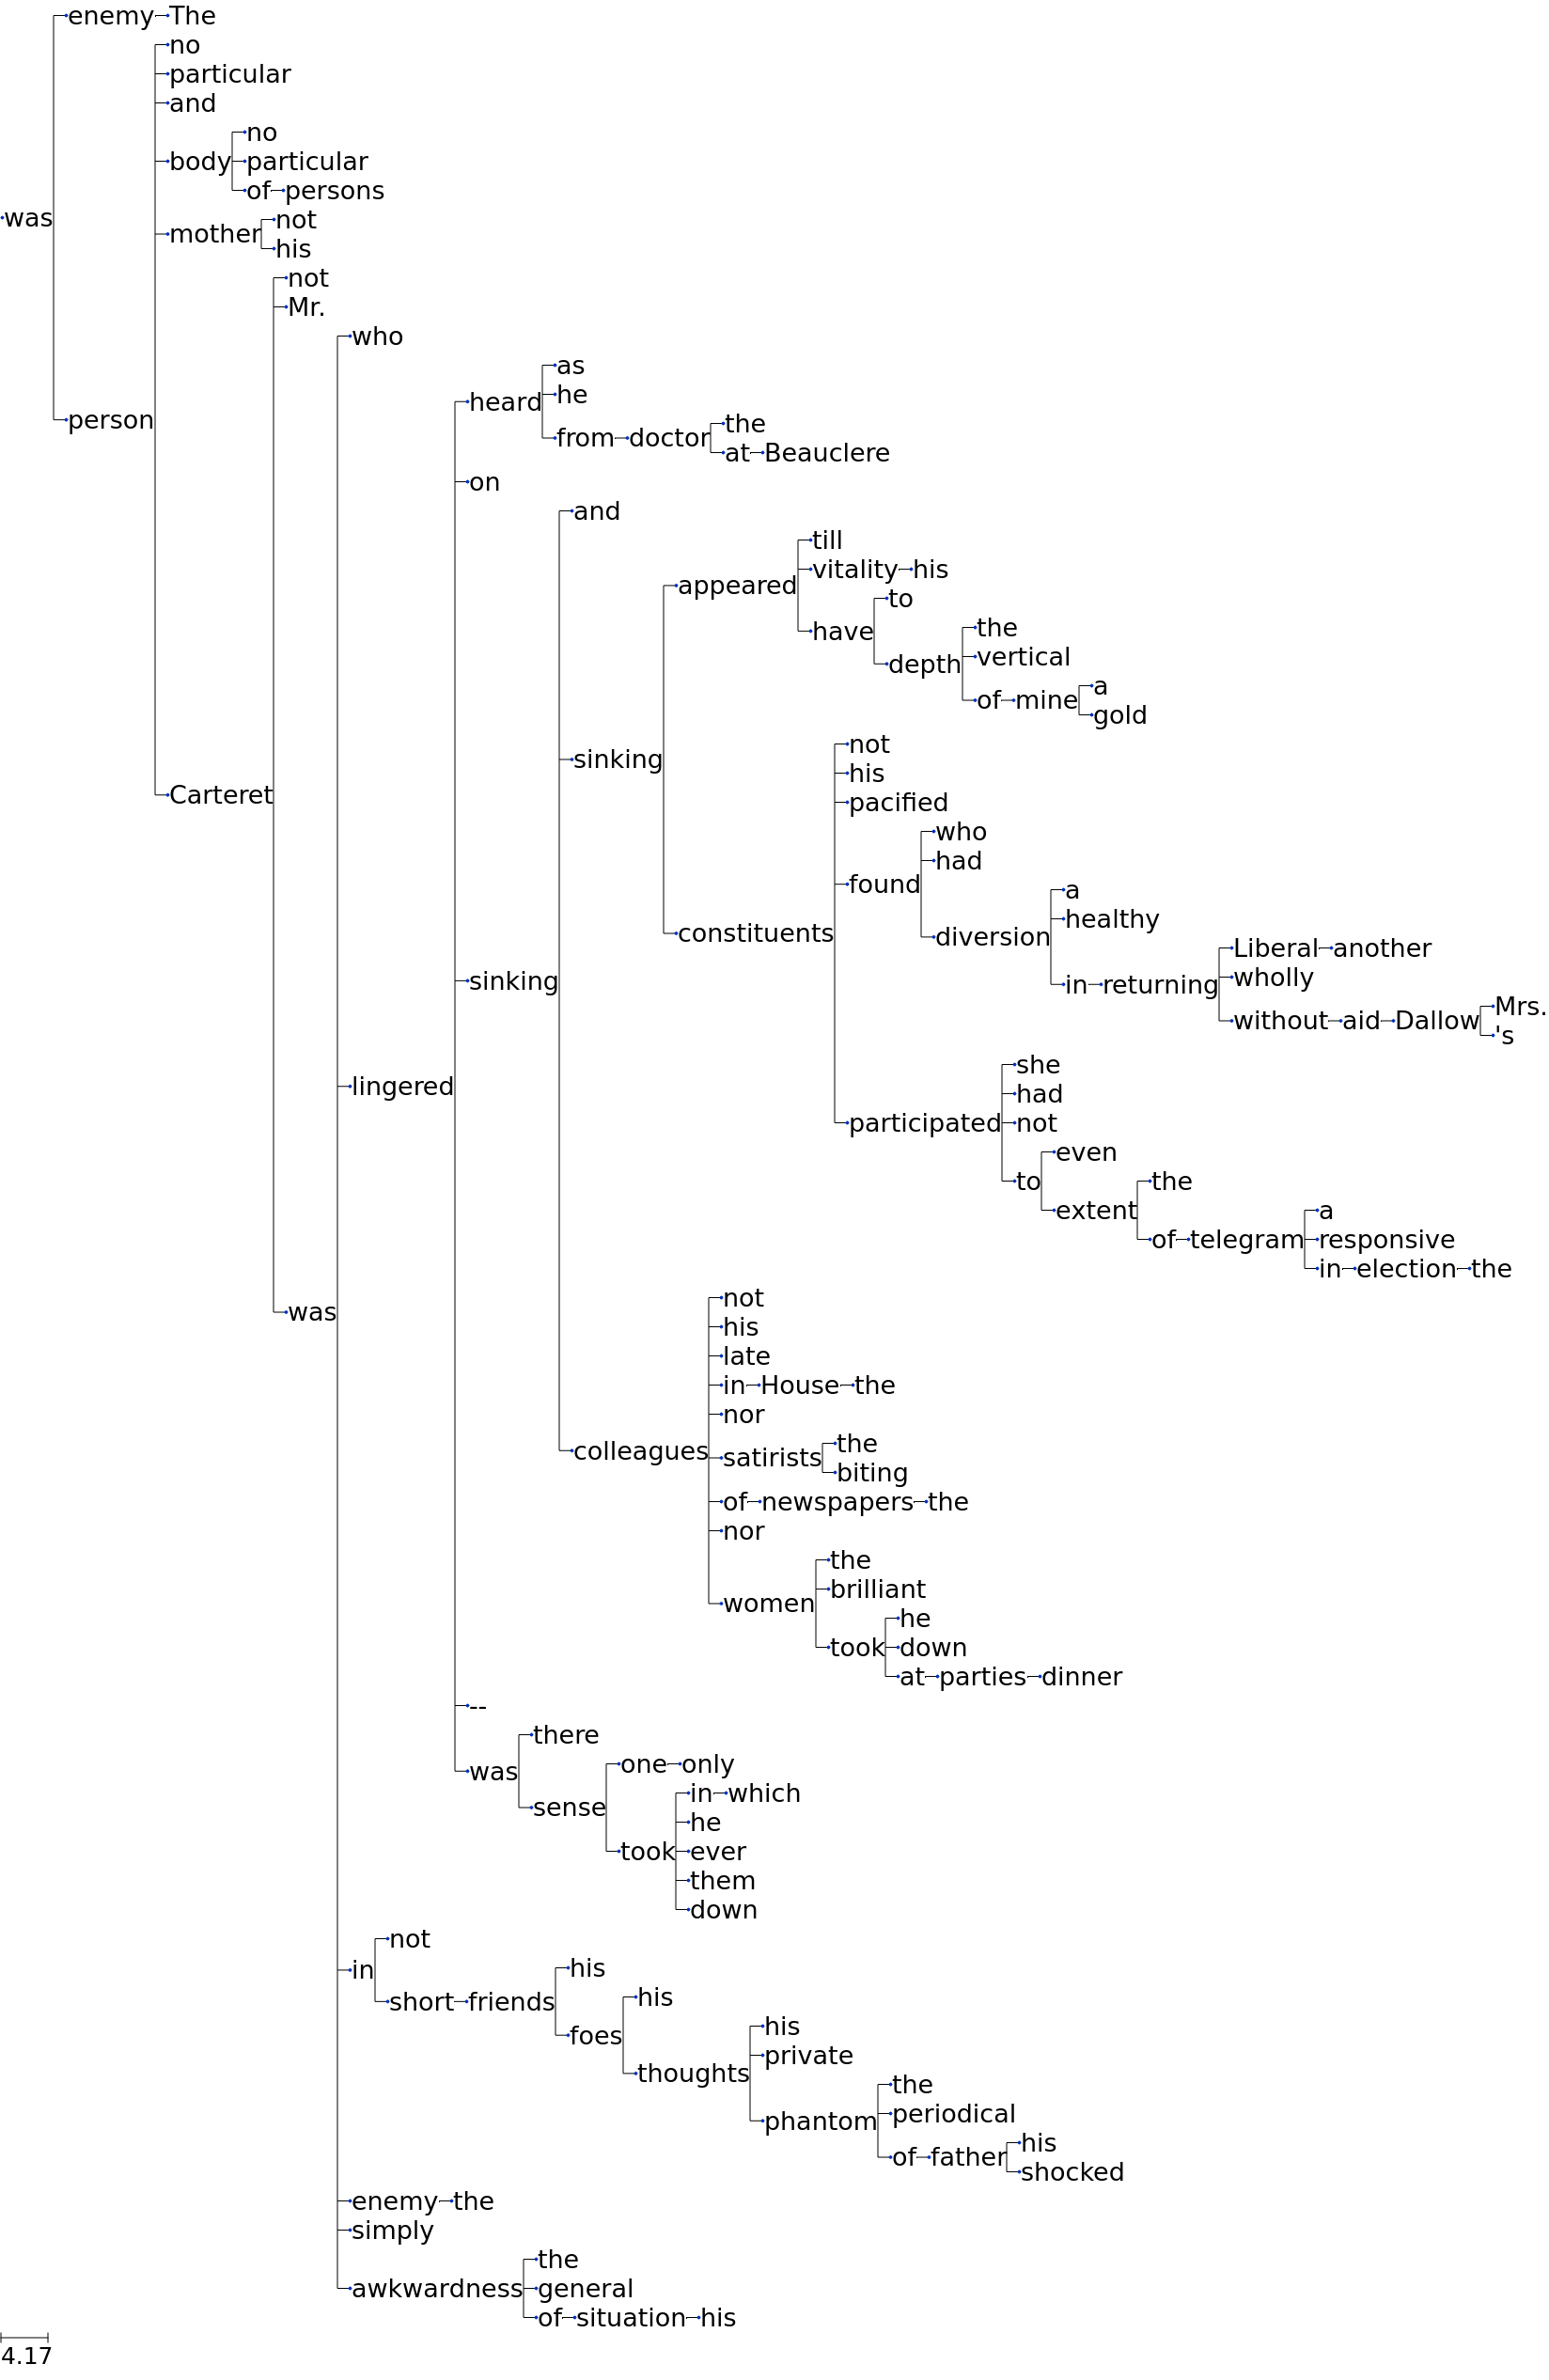

In [225]:
high.render(radial=False)

In [223]:
high.sent.doc

﻿I


The people of France have made it no secret that those of England, as a
general thing, are to their perception an inexpressive and speechless
race, perpendicular and unsociable, unaddicted to enriching any bareness
of contact with verbal or other embroidery. This view might have derived
encouragement, a few years ago, in Paris, from the manner in which four
persons sat together in silence, one fine day about noon, in the garden,
as it is called, of the Palais de l'Industrie--the central court of the
great glazed bazaar where, among plants and parterres, gravelled walks
and thin fountains, are ranged the figures and groups, the monuments and
busts, which form in the annual exhibition of the Salon the department
of statuary. The spirit of observation is naturally high at the Salon,
quickened by a thousand artful or artless appeals, but it need have put
forth no great intensity to take in the characters I mention. As a
solicitation of the eye on definite grounds these visitors too
co